Using TensorFlow backend.


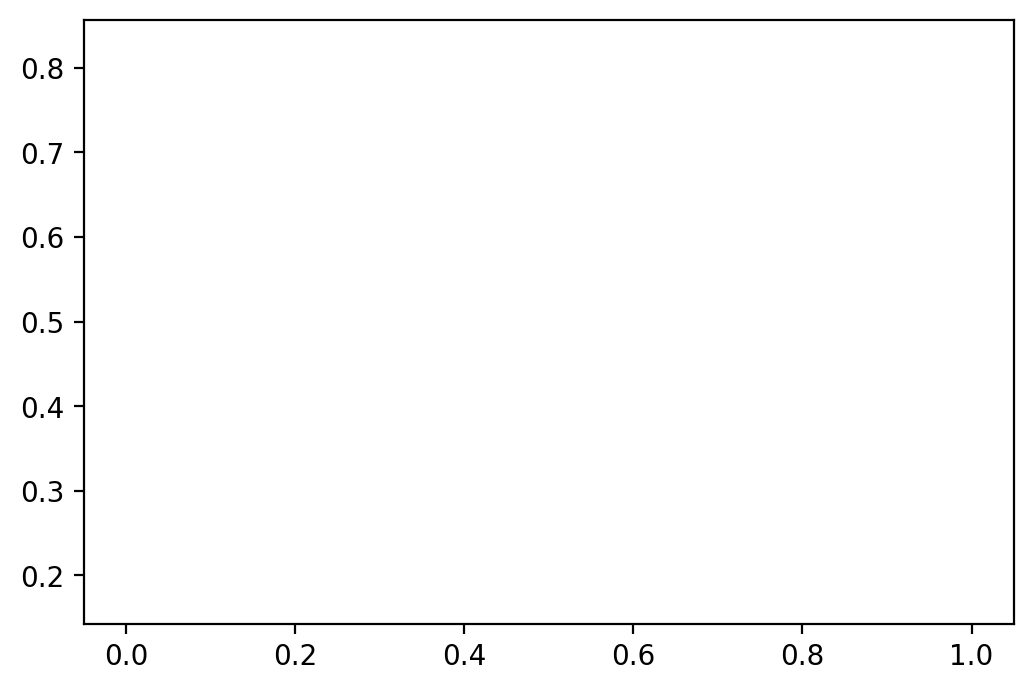

In [1]:
import glob

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


plt.rcParams['figure.dpi'] = 100
plt.ion()
plt.axis('equal')

import numpy as np

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D



In [2]:
def get_num_files(path):
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

def get_num_subfolders(path):
    if not os.path.exists(path):
        return 0
    return sum([len(d) for r, d, files in os.walk(path)])

def create_img_generator():
    return ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

In [3]:
Image_width, Image_height = 299, 299
Training_Epochs = 2
Batch_Size = 3
Number_FC_Neurons = 1024

train_dir = './data/train'
validate_dir = './data/validate'

num_train_samples = get_num_files(train_dir)
num_classes = get_num_subfolders(train_dir)
num_validate_samples = get_num_files(validate_dir)

num_epochs = Training_Epochs
batch_size = Batch_Size



In [4]:
train_image_gen = create_img_generator()
test_image_gen = create_img_generator()

train_generator = train_image_gen.flow_from_directory(
    train_dir,
    target_size=(Image_width, Image_height),
    batch_size=batch_size,
    seed=42
)


validation_generator = test_image_gen.flow_from_directory(
    validate_dir,
    target_size=(Image_width, Image_height),
    batch_size=batch_size,
    seed=42
)


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
InceptionV3_base_model = InceptionV3(weights='imagenet', include_top=False) #excluding final FC layer
print("Loaded inception base model")

W0725 01:30:46.869055 140634593470272 deprecation_wrapper.py:119] From /home/loganathan001/tf_jupyter_gym/tf_jupyter_gym/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 01:30:46.885876 140634593470272 deprecation_wrapper.py:119] From /home/loganathan001/tf_jupyter_gym/tf_jupyter_gym/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 01:30:46.890104 140634593470272 deprecation_wrapper.py:119] From /home/loganathan001/tf_jupyter_gym/tf_jupyter_gym/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 01:30:46.910429 140634593470272 deprecation_wrapper.py:119] From /home/loganathan001/tf_jupyter_gym/tf_jupyter_gym/lib/python3.6/site-packages/keras/backend/tens

Loaded inception base model


In [6]:
x = InceptionV3_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(Number_FC_Neurons, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=InceptionV3_base_model.input, output=predictions)

print("Performing Transfer Learning")

for layer in InceptionV3_base_model.layers:
    layer.trainable=False
    
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/loganathan001/tf_jupyter_gym/tf_jupyter_gym/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
W0725 01:31:01.722048 140634593470272 deprecation_wrapper.py:119] From /home/loganathan001/tf_jupyter_gym/tf_jupyter_gym/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Performing Transfer Learning
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
________________________________________________________________________________

In [ ]:
history_transfer_learning = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=num_train_samples, #batch size
    validation_data=validation_generator,
    validation_steps=num_validate_samples, #batch size
    class_weight='auto'

)

W0725 01:31:01.880574 140634593470272 deprecation.py:323] From /home/loganathan001/tf_jupyter_gym/tf_jupyter_gym/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
 942/2000 [=============>................] - ETA: 15:22 - loss: 0.4955 - acc: 0.7797

In [ ]:
model.save("keras-inceptionv3-transfer-learning.model")

In [ ]:
layers_to_freeze=172
for layer in InceptionV3_base_model.layers[:layers_to_freeze]:
    layer.trainable=False
for layer in InceptionV3_base_model.layers[layers_to_freeze:]:
    layer.trainable=True
    
model.summary()

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_transfer_learning = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=num_train_samples, #batch size
    validation_data=validation_generator,
    validation_steps=num_validate_samples, #batch size
    class_weight='auto'

)

In [ ]:
model.save("keras-inceptionv3-transfer-learning-finetune.model")

In [13]:
from keras.models import load_model
model = load_model('keras-inceptionv3-transfer-learning-finetune.model')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
predicted_value = model.predict_generator(validation_generator, steps=num_validate_samples, verbose=1)
predicted_value

800/800 [==============================] - 757s 947ms/step


array([[9.9821717e-01, 1.7827987e-03],
       [5.3381611e-02, 9.4661832e-01],
       [2.5374544e-01, 7.4625456e-01],
       ...,
       [1.0896256e-04, 9.9989104e-01],
       [9.5444629e-03, 9.9045557e-01],
       [9.2101681e-01, 7.8983240e-02]], dtype=float32)

In [26]:
predicted_value[1].max()

0.9466183